# Libraries

In [5]:
# imports relevant libraries used for building the CNN
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.metrics import precision_score , recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing import image
from tensorflow.keras.models import load_model

# Defining recall, precision, f1 metrics

In [6]:
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [7]:
def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [8]:
def f1_(y_true, y_pred):
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Defining function to plot accuracy and loss of model

In [9]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

# Padding function

In [10]:
"""The function pads all spectrograms to make them uniform 
"""
def padder(list):
    max_check = 0
    for input in list:
        i,j = input.shape
        if max_check < j:
            max_check = j
            
    padded_spectrograms = []
    
    for element in list:
        padded = np.pad(element, [(0,0), (0, max_check - element[0].size)], mode = 'constant', constant_values = 0)
        padded = padded.reshape((padded.shape[0], padded.shape[1], 1))
        padded_spectrograms.append(padded)
        
    padded_spectrograms = np.array(padded_spectrograms)
    
    return padded_spectrograms
            

# Defining the data_loader function

In [69]:
def data_loader():
    # fetches the current working directory
    path = os.getcwd()

    # stores the path for folder containing spectrogram arrays
    spectrogram_path = os.path.join(path,"train")
    # reads the csv folder containing the annotations
    label_chart = pd.read_csv(os.path.join(path, "annotations.csv"))
    # storing the label strings in one list
    labels = label_chart["fname"]
 
    # initialise variable that will store the list of the spectorgram arrays
    spectrograms = []
    
    # using a for loop to store all spectrogram files corresponding to a particular label
    for label in labels:
        spect = np.load(os.path.join(spectrogram_path, label))
        i,j,k = spect.shape
        spect.resize(j,k)
        mel_spectrogram = librosa.power_to_db(spect, ref=np.max)
        spectrograms.append(mel_spectrogram)
        
    padded_spectrograms = padder(spectrograms)
    
    # encoding labels as one-hot vectors
    encoding = label_chart['label']
    one_hot_encoder = LabelEncoder()
    encoded = one_hot_encoder.fit_transform(encoding)
    Y = to_categorical(encoded)
        
    # returns padded spectrograms and one-hot encoded labels     
    return padded_spectrograms, Y

In [65]:
X, Y = data_loader()

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

In [13]:
# The code snippet below was used to ensure that Y test contained an unskewed distribution of the various labels

# unq_rows, count = np.unique(Y_test,axis=0, return_counts=1)
# out = {tuple(i):j for i,j in zip(unq_rows,count)}
# print(out)

In [21]:
def create_model(input_shape):
    model = tf.keras.Sequential()
    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(64, (2, 2), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.25))
        
    # 4th conv layer
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
        
    # 5th conv layer
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GlobalMaxPooling2D())

    # flatten output and feed it into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))

    # output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_, precision_, recall_])
    
    return model

In [22]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = create_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 2582, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 2582, 32)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 126, 2582, 32)    128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 2581, 64)     8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 2581, 64)    0         
 2D)                                                             
                                                        

In [24]:
cp_path = r"C:\Users\Arth Banka\Desktop\Assignment 1\Audio_Classification-MLSP\otherCNN_models\CNN_model"


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    cp_path,
    monitor='val_f1_',
    mode='max',
    save_best_only=True)

In [148]:
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=150, verbose = 2, callbacks=[model_checkpoint_callback])

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_11/conv2d_44/BiasAdd' defined at (most recent call last):
    File "C:\Users\Arth Banka\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Arth Banka\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Arth Banka\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Arth Banka\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Arth Banka\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Arth Banka\AppData\Local\Temp\ipykernel_7552\3267768255.py", line 1, in <cell line: 1>
      history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=30, verbose = 2, callbacks=[model_checkpoint_callback])
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Arth Banka\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 304, in call
      outputs = tf.nn.bias_add(
Node: 'sequential_11/conv2d_44/BiasAdd'
OOM when allocating tensor with shape[32,126,2582,16] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node sequential_11/conv2d_44/BiasAdd}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_99988]

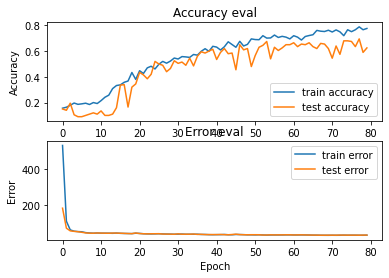

In [124]:
 plot_history(history)

In [ ]:
accuracy = model.evaluate(X_test, Y_test)
print('n', 'Test_Accuracy:-', accuracy[1])
pred=model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
#confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred),cmap="OrRd", annot=True, fmt=".0f", ax=ax)
plt.xlabel("Y_pred")
plt.ylabel("Y_true")
plt.show()

In [17]:
filepath = r"C:\Users\Arth Banka\Desktop\Assignment 1\Audio_Classification-MLSP\Final_models\CNN_model.hdf5"
load_model = tf.keras.models.load_model(
    filepath, custom_objects={'f1_m':f1_, 'precision_m':precision_, 'recall_m':recall_}, compile=True, options=None
)

7/7 [==============================] - 22s 3s/step - loss: 0.1057 - accuracy: 0.9700 - f1_m: 0.9754 - precision_m: 0.9777 - recall_m: 0.9732
n Test_Accuracy:- 0.9700000286102295
7/7 [==============================] - 27s 4s/step
confusion matrix
[[19  0  0  0  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  2]
 [ 0  0  0  0 20  0  0  0  1  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0  0  0 21  2  0]
 [ 0  0  0  0  0  0  0  0 24  0]
 [ 0  0  0  0  0  0  0  0  1 19]]


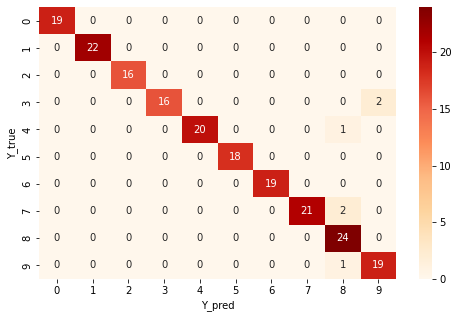

In [18]:
accuracy = load_model.evaluate(X_test, Y_test)
print('n', 'Test_Accuracy:-', accuracy[1])
pred=load_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(Y_test, axis=1)
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
#confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred),cmap="OrRd", annot=True, fmt=".0f", ax=ax)
plt.xlabel("Y_pred")
plt.ylabel("Y_true")
plt.show()

# TESTING

In [35]:
import csv
for file in os.listdir('./Audio_Classification-MLSP-test'):
    df={'f_name':os.listdir('./Audio_Classification-MLSP-test')}

In [36]:
df

{'f_name': ['MLSP_test1053175.npy',
  'MLSP_test1071.npy',
  'MLSP_test1077269.npy',
  'MLSP_test1116162.npy',
  'MLSP_test113179.npy',
  'MLSP_test1134284.npy',
  'MLSP_test1140162.npy',
  'MLSP_test1163322.npy',
  'MLSP_test1186185.npy',
  'MLSP_test1192345.npy',
  'MLSP_test1194176.npy',
  'MLSP_test1205141.npy',
  'MLSP_test1216256.npy',
  'MLSP_test1235269.npy',
  'MLSP_test1277465.npy',
  'MLSP_test1289164.npy',
  'MLSP_test1301172.npy',
  'MLSP_test130220.npy',
  'MLSP_test1306499.npy',
  'MLSP_test130845.npy',
  'MLSP_test132489.npy',
  'MLSP_test1328457.npy',
  'MLSP_test1353495.npy',
  'MLSP_test1357311.npy',
  'MLSP_test1362223.npy',
  'MLSP_test1373407.npy',
  'MLSP_test1379148.npy',
  'MLSP_test1395138.npy',
  'MLSP_test1404304.npy',
  'MLSP_test140846.npy',
  'MLSP_test1443477.npy',
  'MLSP_test1451403.npy',
  'MLSP_test1457299.npy',
  'MLSP_test1458291.npy',
  'MLSP_test1475459.npy',
  'MLSP_test149028.npy',
  'MLSP_test1498106.npy',
  'MLSP_test1515407.npy',
  'MLSP_tes

In [37]:
sig_path = os.path.join(os.getcwd(), "Audio_Classification-MLSP-test")
test_file = df["f_name"]
inputs=[]


for file in test_file:
    arr=np.load(os.path.join(sig_path, file))
    m,n,o=arr.shape
    arr.resize(n,o)
#   print(arr.shape)
    mel_spect = librosa.power_to_db(arr, ref=np.max)
    inputs.append(mel_spect)
    

In [38]:
max_len=0
for input in inputs:
  i,j=input.shape
  if max_len<j:
      max_len=j
features=[]
for a in inputs:
  mat=np.pad(a, [(0, 0), (0, max_len-a[0].size)], mode='constant', constant_values=0)
  mat=mat.reshape((mat.shape[0], mat.shape[1], 1))
  features.append(mat)
max_len=0
features=np.array(features)
for a in features:
  print(a.shape)

(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584, 1)
(128, 2584

In [39]:
i=0
for mat in features:
    features[i]= tf.convert_to_tensor(features[i])
    i=i+1

In [40]:
X_new = features

In [48]:
filepath = r"C:\Users\Arth Banka\Desktop\Assignment 1\Audio_Classification-MLSP\Final_models\Alt_CNN_model.hdf5"
new_model = tf.keras.models.load_model(
    filepath, custom_objects={'f1_m':f1_, 'precision_m':precision_, 'recall_m':recall_}, compile=True, options=None
)


In [49]:
predictions = new_model.predict(X_new)
predictions_decoded = []
for i in predictions:
    predictions_decoded.append(np.argmax(i))


7/7 [==============================] - 41s 6s/step


In [50]:
decode = {0:'Bark', 9:'Walk_and_footsteps', 2:'Doorbell', 1:'Crying_and_sobbing', 7:'Siren', 3:'Knock', 8:'Vehicle_horn_and_car_horn_and_honking', 5:'Microwave_oven', 6:'Shatter', 4:'Meow'}

In [51]:
predictions_string = []
for i in predictions_decoded:
    predictions_string.append(decode[i])

In [52]:
df['prediction'] = predictions_string

In [53]:
Data_frame = pd.DataFrame(df)

In [55]:
Data_frame.to_csv('cnn_predicitons.csv')